In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable, grad
from torch.utils.data import DataLoader, Dataset
from torch_lr_finder import LRFinder

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy
import scipy.io as io
from pyDOE import lhs

from sklearn.metrics import mean_squared_error, mean_absolute_error

from pysr import pysr, best, best_callable
from gplearn.genetic import SymbolicRegressor

from utils import *
import pcgrad
from ladder import LadderNetwork

# AdamGC (Gradient centrailization) optimizer
# Please also try learning finder. (Doesn't have to be included in the paper)
from optimizers import Lookahead, AdamGC, SGDGC  # Not have to report Lookahead and GC

In [2]:
DATA_PATH = "/Users/pongpisit/Desktop/research/pinn/Solving-Differential-Equations-with-Neural-Networks/SymbolicMathematics/data/burgers_shock.mat"

In [3]:
data = io.loadmat(DATA_PATH)

t = data['t'].flatten()[:, None]
x = data['x'].flatten()[:, None]
Exact = np.real(data['usol']).T

X, T = np.meshgrid(x, t)

X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
u_star = Exact.flatten()[:, None]

# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0)

N = 25600
print('The number of training samples:', str(N))
idx = np.random.choice(X_star.shape[0], N, replace=False)
X_u_train = X_star[idx, :]
u_train = u_star[idx, :]

X_u_train = torch.tensor(X_u_train).float().requires_grad_(True)
u_train = torch.tensor(u_train).float().requires_grad_(True)

X_star = torch.tensor(X_star).float().requires_grad_(True)
u_star = torch.tensor(u_star).float().requires_grad_(True)

The number of training samples: 25600


In [4]:
class Network(nn.Module):
    def __init__(self, model, lambda_1_init, lambda_2_init):
        super(Network, self).__init__()
        self.model = model
        print('Init using xavier')
        self.model.apply(self.xavier_init)
        
    def xavier_init(self, m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
        
    def forward(self, data):
        return self.model(data)
    
    def loss(self, data, y_input, include_unsup=False):
        total_loss = []
        
        uf, unsup_loss = self.forward(data)
        
        total_loss.append(F.mse_loss(uf, y_input))
        if unsup_loss: 
            total_loss.append(unsup_loss)
        
        return total_loss
    
    def get_gradients_dict(self, x, t):
        self.eval()
        
        uf, _ = self.forward(x, t)
        
        ### PDE Loss calculation ###
        # first-order derivatives
        u_t = self.gradients(uf, t)[0]
        u_x = self.gradients(uf, x)[0]
        # Homo second-order derivatives
        u_tt = self.gradients(u_t,t)[0]
        u_xx = self.gradients(u_x, x)[0]
        # Hetero second-order derivatives
        u_xt = self.gradients(u_t, x)[0]
        u_tx = self.gradients(u_x, t)[0]
        
        return {'uf':uf, 'u_x':u_x, 'u_xx':u_xx, 'u_tt':u_tt, 'u_xt':u_xt, 'u_tx':u_tx}, u_t
    
    def gradients(self, func, x):
        return grad(func, x, create_graph=True, retain_graph=True, grad_outputs=torch.ones(func.shape))

In [5]:
d_in, hidden_nodes, d_out = 2, 50, 1
bias = True, True
n_layers = 4
activation_function = torch.tanh
noise_std = 0.01

model = LadderNetwork(d_in=d_in, hidden_dims=hidden_nodes, n_layers=n_layers,
                      d_out=d_out, bias=bias, activation_function=activation_function, 
                      noise_std=noise_std)
model

LadderNetwork(
  (encoder): Encoder(
    (stacked_layers): Sequential(
      (layer_0): LinearLayer(
        (linear): Linear(in_features=2, out_features=50, bias=True)
      )
      (layer_1): LinearLayer(
        (linear): Linear(in_features=50, out_features=50, bias=True)
      )
      (layer_2): LinearLayer(
        (linear): Linear(in_features=50, out_features=50, bias=True)
      )
      (layer_3): LinearLayer(
        (linear): Linear(in_features=50, out_features=50, bias=True)
      )
      (layer_4): LinearLayer(
        (linear): Linear(in_features=50, out_features=1, bias=True)
      )
    )
  )
  (decoder): Decoder(
    (stacked_layers): Sequential(
      (layer_0): DecoderLayer(
        (V): Linear(in_features=1, out_features=50, bias=True)
      )
      (layer_1): DecoderLayer(
        (V): Linear(in_features=50, out_features=50, bias=True)
      )
      (layer_2): DecoderLayer(
        (V): Linear(in_features=50, out_features=50, bias=True)
      )
      (layer_3): Decod

Learning rate finding


Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 3.97E-02


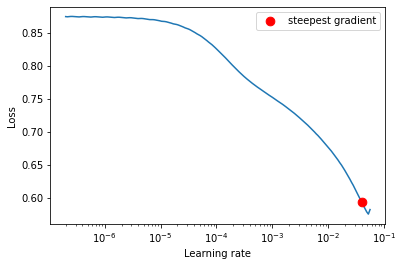

In [6]:
print('Learning rate finding')
criterion = LadderLoss()
tmp_optimizer = SGDGC(model.parameters(), lr=1e-7, use_gc=True, nesterov=True, momentum=0.9)
trainloader = get_dataloader(X_u_train, u_train, bs=4000)
lr_finder = LRFinder(model, optimizer=tmp_optimizer, criterion=criterion, device="cpu")
lr_finder.range_test(trainloader, val_loader=None, end_lr=100, num_iter=300)
_, suggested_lr = lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset()

In [7]:
# Doesn't matter, can be anything.
lambda_1_init = 0.0
lambda_2_init = 0.0

network = Network(model=model, lambda_1_init=lambda_1_init, lambda_2_init=lambda_2_init)

Init using xavier


In [8]:
def pcgrad_closure():
    n_obj = 2 # There are two tasks
    losses = network.loss(X_u_train, u_train, include_unsup=True)
    updated_grads = []
    
    for i in range(n_obj):
        optimizer1.zero_grad()
        losses[i].backward(retain_graph=True)

        g_task = []
        for param in network.parameters():
            if param.grad is not None:
                g_task.append(Variable(param.grad.clone(), requires_grad=False))
            else:
                g_task.append(Variable(torch.zeros(param.shape), requires_grad=False))
        # appending the gradients from each task
        updated_grads.append(g_task)

    updated_grads = list(pcgrad.pc_grad_update(updated_grads))[0]
    for idx, param in enumerate(network.parameters()): 
        param.grad = (updated_grads[0][idx]+updated_grads[1][idx]).requires_grad_(True)
        
    return sum(losses)

def closure():
    if torch.is_grad_enabled():
        optimizer2.zero_grad()
    l = network.loss(X_u_train, u_train, include_unsup=False)[0]
    if l.requires_grad:
        l.backward()
    return l

### Copy weights from network.model.encoder and build a new feedforward model!
### Change a model architecture? (ResNet, ...)

In [9]:
lookahead = False 

# optimizer1 = torch.optim.Adam(network.parameters(), lr=5e-3, use_gc=True, gc_conv_only=False, gc_loc=False)
# optimizer1 = torch.optim.SGD(network.parameters(), lr=5e-3)
optimizer1 = SGDGC(network.parameters(), lr=suggested_lr, use_gc=True, nesterov=True, momentum=0.9)
if lookahead:
    print("Using the lookahead option")
    optimizer1 = Lookahead(optimizer1)
else:
    print("Not using the lookahead option")
    
epochs1 = 1000 # How long this should be ??? (500 seems to be a good number.)
network.train(); best_train_loss = 1e6

print('1st Phase optimization using SGD/Adam with PCGrad gradient modification')
for i in range(epochs1):
    optimizer1.step(pcgrad_closure)
    l = pcgrad_closure()
    
    if (i % 10) == 0 or i == epochs1-1:
        print("Epoch {}: ".format(i), l.item())

if not bias[0]:
    print('Adding encoder biases.')
    # Loading weights to a new encoder model with biases
    # The bias for decoder could be whatever you want, it doesn't matter.
    model = LadderNetwork(d_in=d_in, hidden_dims=hidden_nodes, n_layers=n_layers,
                          d_out=d_out, bias=(True, False), activation_function=activation_function, 
                          noise_std=noise_std)

    # Reinit the biases as 0.01
    model.load_state_dict(network.model.state_dict(), strict=False)

    # delete the old one and create the new network
    del network
    network = Network(model=model, lambda_1_init=lambda_1_init, lambda_2_init=lambda_2_init)

# 2nd Phase optimizer
optimizer2 = torch.optim.LBFGS(network.parameters(), lr=5e-2, max_iter=80, max_eval=100, history_size=120, line_search_fn='strong_wolfe')
epochs2 = 300

print('2nd Phase optimization using LBFGS')
for i in range(epochs2):
    optimizer2.step(closure)
    l = closure()

    if (i % 10) == 0 or i == epochs2-1:
        print("Epoch {}: ".format(i), l.item())

Not using the lookahead option
1st Phase optimization using SGD/Adam with PCGrad gradient modification
Epoch 0:  0.8142675161361694
Epoch 10:  0.5815798044204712
Epoch 20:  0.4952782690525055
Epoch 30:  0.49043548107147217
Epoch 40:  0.47902101278305054
Epoch 50:  0.4710279107093811
Epoch 60:  0.4521389603614807
Epoch 70:  0.4057096838951111
Epoch 80:  0.34631744027137756
Epoch 90:  0.3283379077911377
Epoch 100:  0.32037219405174255
Epoch 110:  0.30951255559921265
Epoch 120:  0.2997129559516907
Epoch 130:  0.2911298871040344
Epoch 140:  0.28089380264282227
Epoch 150:  0.27101579308509827
Epoch 160:  0.26485371589660645
Epoch 170:  0.26070165634155273
Epoch 180:  0.25719940662384033
Epoch 190:  0.2545551657676697
Epoch 200:  0.2524283230304718
Epoch 210:  0.25054705142974854
Epoch 220:  0.24894201755523682
Epoch 230:  0.24751614034175873
Epoch 240:  0.24622085690498352
Epoch 250:  0.24503739178180695
Epoch 260:  0.2439347803592682
Epoch 270:  0.24290482699871063
Epoch 280:  0.2419224232

### Evaluate the MSE loss comparing btw with & without the sparsity (Average the results from 5 evaluations?)
### The better one would benefit the Symbolic regression process to recover PDE relation.

In [10]:
((network(X_star)[0].detach() - u_star)**2).mean().item() # BEST: 5.905130819883198e-07

7.889057656029763e-07

### Precise pde parameters recovery using the PINN technique

In [ ]:
# lambda_1_init, lambda_2_init = network.get_theta(X_u_train[:, 0:1], X_u_train[:, 1:2])
# network.set_lambdas(lambda_1_init, lambda_2_init)

lambda_1_init = 0.6860763
lambda_2_init = np.log(0.0020577204)

### Choosing btw reset model weights or pretraining ###
network = Network(model=model, lambda_1_init=lambda_1_init, lambda_2_init=lambda_2_init)
optimizer = torch.optim.LBFGS(network.parameters(), lr=5e-2, max_iter=50, max_eval=50, line_search_fn='strong_wolfe')

network.train(); best_train_loss = 1e6
for i in range(epochs):
    ### Add the closure function to calculate the gradient. For LBFGS.
    def closure():
        if torch.is_grad_enabled():
            optimizer.zero_grad()
        l = network.loss(X_u_train[:, 0:1], X_u_train[:, 1:2], u_train, is_pde_parameters_update=True)
        if l.requires_grad:
            l.backward()
        return l

    optimizer.step(closure)

    # calculate the loss again for monitoring
    l = closure()

    if i > 400 and float(l.item()) < best_train_loss:
        torch.save(network.state_dict(), 'nn_with_physical_reg_from_symreg.pth')
        best_train_loss = float(l.item())

    if (i % 100) == 0:
        print("Epoch {}: ".format(i), l.item())

In [ ]:
### Loading the best weights ###
network.load_state_dict(torch.load(weights_path))

In [ ]:
network.eval()

In [ ]:
nu = 0.01 / np.pi

error_lambda_1 = np.abs(network.lambda_1.detach().item() - 1.0)*100
error_lambda_2 = np.abs(torch.exp(network.lambda_2).detach().item() - nu) / nu * 100

error_lambda_1, error_lambda_2

In [ ]:
1.0, network.lambda_1.detach().item()

In [ ]:
nu, torch.exp(network.lambda_2).detach().item()

### Symbolic regression

In [ ]:
grads_dict, target = network.get_gradients_dict(X_u_train[:, 0:1], X_u_train[:, 1:2])
index2features = grads_dict.keys()
print(index2features)

G = torch.cat(list(grads_dict.values()), dim=1).detach().numpy()
target = torch.squeeze(target).detach().numpy()

In [ ]:
equations = pysr(G, target, niterations=20, binary_operators=["plus", "sub", "mult"], unary_operators=[], batching=True, procs=4, populations=10, npop=2000)


In [ ]:
# Choose the one with best score => might be overfitting (the lowest loss)
print(best(equations))
# fn = best_callable(equations)

In [ ]:
df = equations.drop(labels='lambda_format', axis=1)
df.to_pickle('./saved_path_inverse_burger/equations_from_pysr.pkl')

In [ ]:
### The one config that I used, and it was giving a good approx symbolic representation of the data. ###

# (1)
# est_gp = SymbolicRegressor(population_size=50000, generations=20, function_set=('add', 'sub', 'mul'),
#                            p_crossover=0.7, p_subtree_mutation=0.1, p_hoist_mutation=0.05,
#                            p_point_mutation=0.1, max_samples=0.9, parsimony_coefficient=0.001,
#                            verbose=1, low_memory=True, n_jobs=2)

# (2)
# est_gp = SymbolicRegressor(population_size=60000, generations=20, function_set=('add', 'sub', 'mul'),
#                            p_crossover=0.7, p_subtree_mutation=0.1, p_hoist_mutation=0.05,
#                            p_point_mutation=0.1, max_samples=0.9, parsimony_coefficient=0.001,
#                            verbose=1, low_memory=True, n_jobs=-1)

# const_range=(-1. float(G.shape[1])) ?

### Current experiment ###
est_gp = SymbolicRegressor(population_size=60000, generations=25, function_set=('add', 'sub', 'mul'),
                           p_crossover=0.7, p_subtree_mutation=0.1, p_hoist_mutation=0.05,
                           p_point_mutation=0.1, max_samples=0.9, parsimony_coefficient=0.001,
                           verbose=1, low_memory=True, n_jobs=-1)

est_gp.fit(G, target)

In [ ]:
from utils import build_exp
program = est_gp._program
print(build_exp(program))

In [ ]:
# from utils import pickle_save
# pickle_save(est_gp, './data/gp_symreg_with_noisy_features.pkl')

In [ ]:
# Exreacted equation (for further fine-tuning)
# u_t + 0.6860763*uf*u_x - 0.0020577204*u_xx